In [1]:
import datetime as dt
from jinja2 import Template
from pytz import timezone
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import HTML
from money_squirrel.bin import utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

COINS = utils.load_config("coins")

def display_all(df):
    return HTML(df.to_html())

2017-06-28 07:51:21,288|money_squirrel.bin.utils|INFO|Instantiated logger w/ name=money_squirrel.bin.utils
2017-06-28 07:51:21,292|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/coins.json


# vectorization

- Easy way to create features is to make rolling means over periods of time
- Easy to create a function which will do this

In [2]:
sample_df = utils.query_pg("""
    select *
    from gdax_api_quote
    where product_id = 'BTC-USD'
    order by dt
    limit 10000
""")

2017-06-28 07:51:25,077|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-06-28 07:51:25,078|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-06-28 07:51:25,083|money_squirrel.bin.utils|INFO|Executing query:


    select *
    from gdax_api_quote
    where product_id = 'BTC-USD'
    order by dt
    limit 10000




In [3]:
sample_df.head()

,id,product_id,granularity,dt,low,high,open,close,volume
0,216,BTC-USD,60,2017-01-01 00:00:00+00:00,973.35,973.37,973.37,973.35,2.122048
1,215,BTC-USD,60,2017-01-01 00:03:00+00:00,973.36,973.36,973.36,973.36,0.040000
2,214,BTC-USD,60,2017-01-01 00:04:00+00:00,973.36,973.40,973.36,973.39,5.458800
3,213,BTC-USD,60,2017-01-01 00:05:00+00:00,973.35,973.39,973.35,973.38,12.481567
4,212,BTC-USD,60,2017-01-01 00:06:00+00:00,973.38,973.39,973.39,973.38,1.496540


In [4]:
sample_df['dt'].max()

Timestamp('2017-01-08 01:40:00+0000', tz='UTC')

In [5]:
dr = pd.date_range(
    start=sample_df['dt'].min(),
    end=sample_df['dt'].max(),
    freq='1Min'
)
dr

DatetimeIndex(['2017-01-01 00:00:00+00:00', '2017-01-01 00:01:00+00:00',
               '2017-01-01 00:02:00+00:00', '2017-01-01 00:03:00+00:00',
               '2017-01-01 00:04:00+00:00', '2017-01-01 00:05:00+00:00',
               '2017-01-01 00:06:00+00:00', '2017-01-01 00:07:00+00:00',
               '2017-01-01 00:08:00+00:00', '2017-01-01 00:09:00+00:00',
               ...
               '2017-01-08 01:31:00+00:00', '2017-01-08 01:32:00+00:00',
               '2017-01-08 01:33:00+00:00', '2017-01-08 01:34:00+00:00',
               '2017-01-08 01:35:00+00:00', '2017-01-08 01:36:00+00:00',
               '2017-01-08 01:37:00+00:00', '2017-01-08 01:38:00+00:00',
               '2017-01-08 01:39:00+00:00', '2017-01-08 01:40:00+00:00'],
              dtype='datetime64[ns, UTC]', length=10181, freq='T')

In [6]:
sample_df.dt.value_counts().value_counts()

1    10000
Name: dt, dtype: int64

In [7]:
all_times_sample = (
    sample_df
    .merge(
        pd.DataFrame({'dt_': dr}),
        how='right',
        left_on='dt',
        right_on='dt_'
    )
)

In [8]:
all_times_sample.head()

,id,product_id,granularity,dt,low,high,open,close,volume,dt_
0,216.0,BTC-USD,60.0,2017-01-01 00:00:00+00:00,973.35,973.37,973.37,973.35,2.122048,2017-01-01 00:00:00+00:00
1,215.0,BTC-USD,60.0,2017-01-01 00:03:00+00:00,973.36,973.36,973.36,973.36,0.040000,2017-01-01 00:03:00+00:00
2,214.0,BTC-USD,60.0,2017-01-01 00:04:00+00:00,973.36,973.40,973.36,973.39,5.458800,2017-01-01 00:04:00+00:00
3,213.0,BTC-USD,60.0,2017-01-01 00:05:00+00:00,973.35,973.39,973.35,973.38,12.481567,2017-01-01 00:05:00+00:00
4,212.0,BTC-USD,60.0,2017-01-01 00:06:00+00:00,973.38,973.39,973.39,973.38,1.496540,2017-01-01 00:06:00+00:00


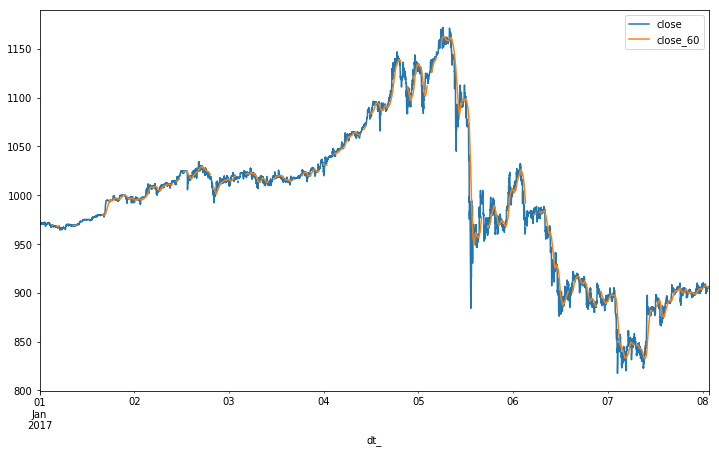

In [9]:
(
    all_times_sample
    .sort_values('dt_')
    .assign(close_60 = lambda df: df['close'].rolling(60).mean())
    .set_index('dt_')
    .loc[:, ['close', 'close_60']]
    .plot()
)

In [62]:
DEFAULT_MINUTES = [
    1, 
    #10,
    #20,
    30,
    60,
    60*4,
    #60*8,
    60*12,
    60*24
]

def get_rolling_data(
    product_id='BTC-USD', 
    start_dt=dt.datetime(2017,2,1), 
    end_dt=dt.datetime(2017,2,7), 
    minutes=DEFAULT_MINUTES):
    query_template = """
        select distinct dt
            , close
            , volume
        from gdax_api_quote
        where product_id = '{{ product_id }}'
            and granularity = 60
            and dt >= TIMESTAMP '{{ start_date }}'
            and dt <= TIMESTAMP '{{ end_date }}' 
                - INTERVAL '{{ max_minutes }} minutes'
    """
    df = (
        utils.query_pg(
            Template(query_template)
            .render(
                product_id=product_id,
                start_date=start_dt.strftime(utils.ISO),
                end_date=end_dt.strftime(utils.ISO),
                max_minutes=max(minutes)
            )
        )
        .set_index('dt')
        .sort_index()
    )
    for m in minutes:
        df['close_avg_{}'.format(m)] = df['close'].rolling('{}Min'.format(m)).mean()
        df['volume_avg_{}'.format(m)] = df['volume'].rolling('{}Min'.format(m)).mean()
    return df

In [63]:
frame = get_rolling_data()

2017-06-28 08:18:01,795|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-06-28 08:18:01,796|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-06-28 08:18:01,800|money_squirrel.bin.utils|INFO|Executing query:


        select distinct dt
            , close
            , volume
        from gdax_api_quote
        where product_id = 'BTC-USD'
            and granularity = 60
            and dt >= TIMESTAMP '2017-02-01T00:00:00'
            and dt <= TIMESTAMP '2017-02-07T00:00:00' 
                - INTERVAL '1440 minutes'
    



In [64]:
frame

,close,volume,close_avg_1,volume_avg_1,close_avg_30,volume_avg_30,close_avg_60,volume_avg_60,close_avg_240,volume_avg_240,close_avg_720,volume_avg_720,close_avg_1440,volume_avg_1440
dt,,,,,,,,,,,,,,
2017-02-01 08:00:00+00:00,978.86,1.548306,978.86,1.548306,978.860000,1.548306,978.860000,1.548306,978.860000,1.548306,978.860000,1.548306,978.860000,1.548306
2017-02-01 08:01:00+00:00,978.58,0.020000,978.58,0.020000,978.720000,0.784153,978.720000,0.784153,978.720000,0.784153,978.720000,0.784153,978.720000,0.784153
2017-02-01 08:02:00+00:00,978.72,3.366869,978.72,3.366869,978.720000,1.645058,978.720000,1.645058,978.720000,1.645058,978.720000,1.645058,978.720000,1.645058
2017-02-01 08:03:00+00:00,979.37,5.500000,979.37,5.500000,978.882500,2.608794,978.882500,2.608794,978.882500,2.608794,978.882500,2.608794,978.882500,2.608794
2017-02-01 08:04:00+00:00,979.33,0.427531,979.33,0.427531,978.972000,2.172541,978.972000,2.172541,978.972000,2.172541,978.972000,2.172541,978.972000,2.172541
2017-02-01 08:05:00+00:00,979.44,0.993000,979.44,0.993000,979.050000,1.975951,979.050000,1.975951,979.050000,1.975951,979.050000,1.975951,979.050000,1.975951
2017-02-01 08:06:00+00:00,978.95,2.102363,978.95,2.102363,979.035714,1.994010,979.035714,1.994010,979.035714,1.994010,979.035714,1.994010,979.035714,1.994010
2017-02-01 08:07:00+00:00,978.00,5.836500,978.00,5.836500,978.906250,2.474321,978.906250,2.474321,978.906250,2.474321,978.906250,2.474321,978.906250,2.474321
2017-02-01 08:08:00+00:00,978.10,5.778600,978.10,5.778600,978.816667,2.841463,978.816667,2.841463,978.816667,2.841463,978.816667,2.841463,978.816667,2.841463


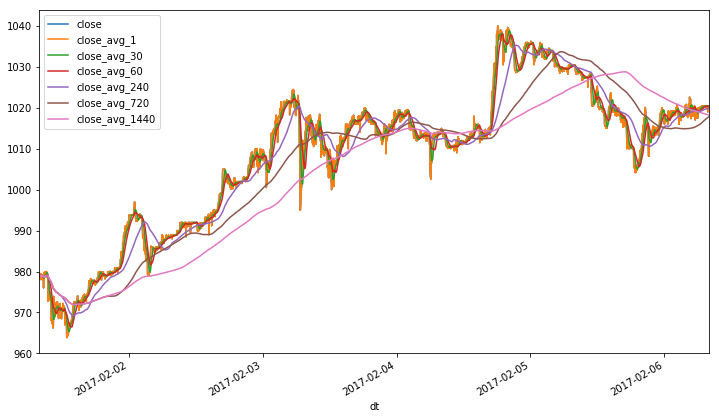

In [66]:
frame.loc[:, [c for c in frame.columns if 'close' in c]].plot()

In [34]:
pd.DataFrame({'dt_': pd.to_datetime(dr)})

,dt_
0,2017-02-01 00:00:00
1,2017-02-01 00:01:00
2,2017-02-01 00:02:00
3,2017-02-01 00:03:00
4,2017-02-01 00:04:00
5,2017-02-01 00:05:00
6,2017-02-01 00:06:00
7,2017-02-01 00:07:00
8,2017-02-01 00:08:00
9,2017-02-01 00:09:00


In [36]:
frame.merge(
    pd.DataFrame({'dt_': dr}),
    how='right',
    left_on='dt',
    right_on='dt_'
)

TypeError: type object argument after * must be a sequence, not itertools.imap

In [23]:
frame = (
    frame
    .merge(
        pd.DataFrame({'dt_': dr}),
        how='right',
        left_on='dt',
        right_on='dt_'
    )
)

TypeError: type object argument after * must be a sequence, not itertools.imap

In [ ]:
df.head().T

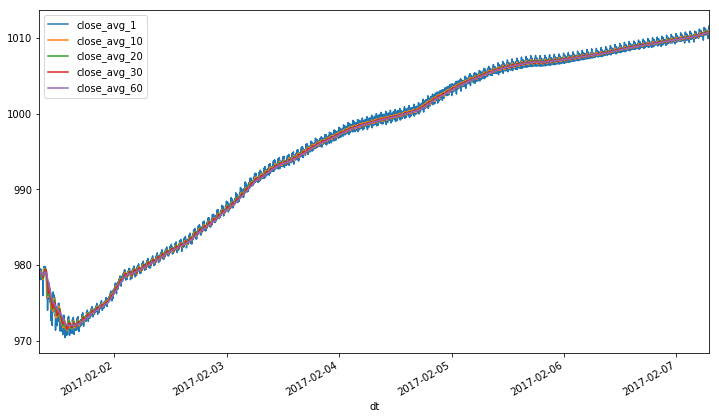

In [24]:
(
    df
    .set_index('dt')
    .loc[:, [c for c in df.columns if 'close' in c]]
    .plot()
)